In [0]:
!curl https://course-v3.fast.ai/setup/colab | bash 

In [0]:
from fastai import *
from fastai.text import * 
import fastai.utils.collect_env
fastai.utils.collect_env.show_install() # may have changed to python -m fastai.utils.show_install
#fastai.check_perf()

def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    if use_cuda: 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False
        
# to get reproducible measures across runs and kernel restarts, use the above random_seed function and 
# pass num_workers=0 when generating the DataBunch. 
# Non-repeatabilty was leaking in through CudaNN and the data loader workers.

random_seed(42, True)

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: 

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
# create a data folder and copy train and test data into it 
# ......... awaiting for clearnce from reuters to publish the news titles as dataset 

Path('data/reuters/').mkdir(parents=True, exist_ok=True)
!cp '/gdrive/My Drive/ulmfit/aiecom/reuters_corpus_2012_2017_ar.zip' data/reuters/

In [0]:
path=Path('data/reuters/')

In [5]:
df_ar = pd.read_csv(path/'reuters_corpus_2012_2017_ar.zip')
df_ar.head()

,Unnamed: 0,id,title,date,category
0,0,0,مصر تعتزم خفض الدعم على الطاقة للصناعات كثيفة ...,1012012,business
1,1,1,بريطانيا تبيع نورذرن روك لفيرجين رغم اعتراضات,1012012,business
2,2,2,إيران تكثف الضغط على الكويت حول حقل للغاز,1012012,business
3,3,3,اكسون تحصل على حكم بتعويض 908 ملايين دولار في ...,1012012,business
4,4,4,غرفة التجارة: ارتفاع أسعار التجزئة في اسطنبول ...,1012012,business


In [0]:
df_ar = df_ar[['category', 'title']]

In [7]:
df_ar['category'].value_counts()

business         54300
world_news       51214
top_news         39773
sports           28181
sci_env          12598
entertainment    11382
Name: category, dtype: int64

In [8]:
# remove top_news as it causes confusion (usually belongs to other categories)
df = df_ar.loc[df_ar['category'].isin(['business','world_news', 'sports', 'sci_env', 'entertainment'])]
df['category'].value_counts()

business         54300
world_news       51214
sports           28181
sci_env          12598
entertainment    11382
Name: category, dtype: int64

In [9]:
# limit to least number of items to balance
df5 = df.groupby('category').apply(lambda grp: grp.sample(n=11382))
df5['category'].value_counts()

world_news       11382
business         11382
entertainment    11382
sports           11382
sci_env          11382
Name: category, dtype: int64

In [10]:
df_valid = df5.sample(2275, replace = False) # 20% for validation
df_valid['is_valid'] = True
df_train = df5.drop(df_valid.index)
df_train['is_valid'] = False

df_all = pd.concat([df_train, df_valid])
df_all.head()

category                                              title  \
category                                                                      
business 52215  business  نيكي يتراجع مع انخفاض عوائد السندات إلى مستوى ...   
         3633   business  النفط برتفع لحوالي 116 دولارا بفضل آمال تحفيز ...   
         28877  business  الذهب يتراجع مع استقرار الدولار واستمرار شكوك ...   
         23437  business  باركليز يفضل النيكل في 2014 وينصح بالابتعاد عن...   
         44869  business  مقابلة-البنك الدولي يقول إصلاحات مصر يجب أن تر...   

                is_valid  
category                  
business 52215     False  
         3633      False  
         28877     False  
         23437     False  
         44869     False

In [11]:
df_valid['category'].value_counts()

business         471
sports           458
world_news       449
entertainment    449
sci_env          448
Name: category, dtype: int64

In [0]:
# write to csv (overwrites by default)
df_all.to_csv(path/'news_text.csv', index=False)

In [13]:
# ------------------------------------------------------------------------
# from here, we follow fastai tutorial at https://docs.fast.ai/text.html
df = pd.read_csv(path/'news_text.csv')
df.head()

,category,title,is_valid
0,business,نيكي يتراجع مع انخفاض عوائد السندات إلى مستوى ...,False
1,business,النفط برتفع لحوالي 116 دولارا بفضل آمال تحفيز ...,False
2,business,الذهب يتراجع مع استقرار الدولار واستمرار شكوك ...,False
3,business,باركليز يفضل النيكل في 2014 وينصح بالابتعاد عن...,False
4,business,مقابلة-البنك الدولي يقول إصلاحات مصر يجب أن تر...,False


In [0]:
#wget gives forbidden, download and upload to gdrive
!rm -rf data/reuters/models
!rm -rf data/reuters/tmp
#!rm -rf models/
#Path('models/').mkdir(parents=True, exist_ok=True)

In [0]:
#ls -la 
!cp '/gdrive/My Drive/ulmfit/ar2/ar45/30k/lm_best.pth' models/
!cp '/gdrive/My Drive/ulmfit/ar2/ar45/30k/itos.pkl' models/

In [0]:
# Language model data
data_lm = TextLMDataBunch.from_csv(path, 'news_text.csv')
# Classifier model data
data_clas = TextClasDataBunch.from_csv(path, 'news_text.csv', vocab=data_lm.train_ds.vocab, bs=64, num_workers=0)

In [0]:
data_lm.save()
data_clas.save()
data_lm = TextLMDataBunch.load(path)
data_clas = TextClasDataBunch.load(path, bs=64)

In [0]:
pretrained_fnames=['/content/models/lm_best','/content/models/itos']

epoch,train_loss,valid_loss,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


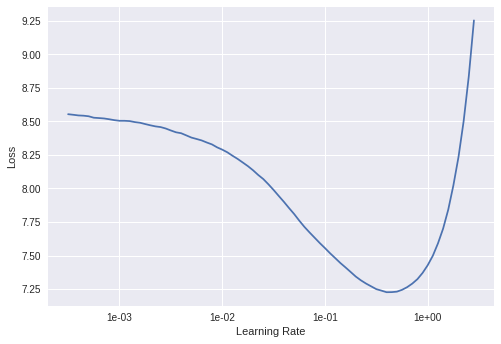

In [18]:
learn = language_model_learner(data_lm, pretrained_fnames=pretrained_fnames, drop_mult=0.1) # was .5
learn.lr_find(start_lr = slice(10e-7,10e-5),end_lr=slice(0.1,10))#start_lr = slice(10e-7,10e-5),end_lr=slice(0.1,10))
learn.recorder.plot(skip_end=10)

In [20]:
learn.fit_one_cycle(1, 4e-2)

epoch,train_loss,valid_loss,accuracy
1,5.646002,5.250086,0.227174


In [21]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-3,1e-1))

epoch,train_loss,valid_loss,accuracy
1,4.568991,4.587829,0.284613
2,4.231137,4.311650,0.316373
3,3.590477,3.930613,0.368364
4,2.672477,3.552130,0.448958
5,1.998346,3.554797,0.469776


In [22]:
learn.predict("انسحاب القوات", n_words=5)

'انسحاب القوات برؤية مثيرة فيليب الأحفوري والتعمير'

In [23]:
# first amount of words (here 10), the next 10 target words (actual) and the ones predicted.
learn.show_results(max_len = 6)

text,target,pred
xxbos مالي تشتبه في أول اصابة,الايبولا مع تجاوز وفيات المنطقة 90,زيكا . تجاوز مستوياتها المنطقة 90
xxbos اصابة مصور امريكي يعمل لشبكة,إن . بي . سي بالايبولا,هندية الاماراتي بي باريبا سي بالايبولا
أدوار المنافسة على اللقب في المكسيك,تقرير : تويتر تبحث رفع الحد,فينجر تايواني إدمان ستعقد رفع الحد
مصر والمغرب والعراق يفوزون بجائزة الشيخ,2016 xxbos مهرجان في السعودية للحفاظ,للكتاب - ميشيل سينمائي السماء للحفاظ
قضية الاستبداد في الفكر السياسي الإسلامي,قائد أمريكي : أفغانستان بحاجة لدعم,وزنياكي بالحرس يخضع إستراتيجية يطلبون الإرهابية


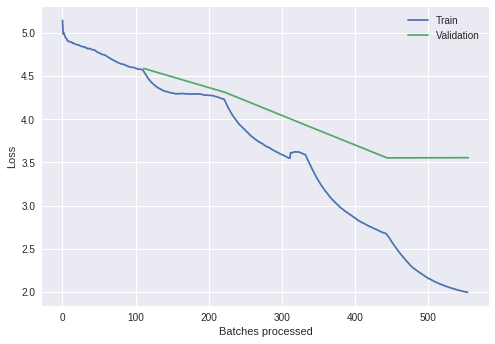

In [24]:
learn.save_encoder('ft_enc')
learn.recorder.plot_losses()

In [0]:
#classifier
learn_clas = text_classifier_learner(data_clas, drop_mult=0.5)
learn_clas.load_encoder('ft_enc')

In [26]:
data_clas.show_batch(2)

text,target
xxbos مقابلة - رئيس تداول : xxunk إلى تطبيق آلية ( xxup xxunk ) قبل مراجعة إم . اس . سي . آي للتصنيف السعودي في يونيو,business
xxbos عمليات ( او . إم . في ) xxunk في ليبيا لم تتأثر جراء انفجار في خط أنابيب,business


epoch,train_loss,valid_loss,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


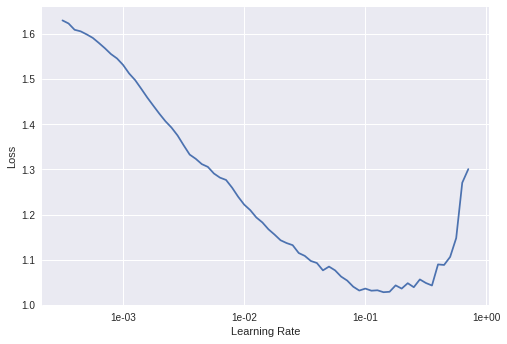

In [27]:
learn_clas.lr_find(start_lr = slice(10e-7,10e-5),end_lr=slice(0.1,10))
learn_clas.recorder.plot(skip_end=10)

In [28]:
learn_clas.fit_one_cycle(1, 5e-3)

epoch,train_loss,valid_loss,accuracy
1,0.602384,0.449486,0.835808


In [29]:
learn_clas.freeze_to(-2)
learn_clas.fit_one_cycle(1, 2e-3)

epoch,train_loss,valid_loss,accuracy
1,0.509054,0.386798,0.861548


In [30]:
learn_clas.unfreeze()
learn_clas.fit_one_cycle(5, 2e-3)

epoch,train_loss,valid_loss,accuracy
1,0.413703,0.339160,0.881754
2,0.386218,0.298221,0.894755
3,0.280060,0.249428,0.916630
4,0.223554,0.228464,0.922955
5,0.180743,0.225633,0.924976


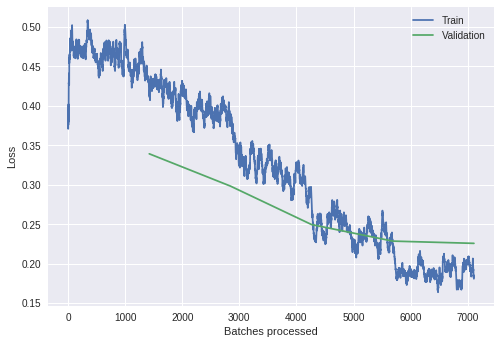

In [32]:
learn_clas.recorder.plot_losses()

In [33]:
# extra from deep French 
# https://github.com/tchambon/deepfrench/blob/master/ULMFit%20Classifier%20example.ipynb
learn_clas.freeze_to(-3)
learn_clas.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy
1,0.199299,0.222254,0.926821


In [34]:
learn_clas.unfreeze()
learn_clas.fit_one_cycle(4, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.166583,0.224842,0.929368
2,0.177946,0.219182,0.932267
3,0.146617,0.219140,0.933058
4,0.119597,0.219995,0.933409


In [35]:
learn_clas.fit_one_cycle(2, 2e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.213343,0.234883,0.925591
2,0.147348,0.220090,0.933058


In [36]:
print(learn_clas.validate()) 

[0.22009039, tensor(0.9331)]


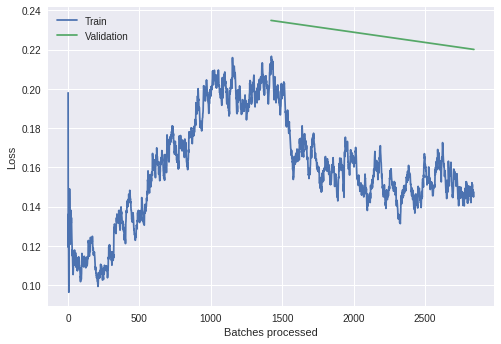

In [37]:
learn_clas.recorder.plot_losses()

In [38]:
learn_clas.show_results(rows=20)

text,target,prediction
xxbos مسؤول : بنك ( xxunk . آي . آي . بي ) الذي xxunk الصين لن xxunk عن أي فساد xxunk الاقتصاد,business,business
"xxbos أوباما : يجب على العالم أن يتوصل لاتفاق بشأن المناخ في باريس "" بينما لا يزال هذا في xxunk """,world_news,sci_env
xxbos بي . إم . دبليو وانتل وموبايل آي يختبرون 40 سيارة بدون سائق في النصف / 2 من 2017,sci_env,business
xxbos جازبروم : لم xxunk شراء حصة بي . بي في تي . ان . كي - بي . بي,business,business
xxbos بي . إم . دبليو وانتل وموبايل آي يختبرون 40 سيارة بدون سائق في النصف / 2 من 2017,sci_env,business
xxbos مقابلة - xxunk المصرية : طرح أسهم رؤية في البورصة في النصف / 2 xxunk مرتقبة 2.5 مليار جنيه,business,business
xxbos مسح : إنتاج قطاع الصناعات التحويلية في بريطانيا ينكمش بأسرع وتيرة له في أكثر من 3 سنوات بعد الاستفتاء,business,business
xxbos إف . بي . آي : أكثر من 200 أمريكي xxunk أو حاولوا السفر لسوريا للقتال مع xxunk,world_news,world_news
xxbos ( حتى على الموت لا xxunk من xxunk ) .. امرأة تسرق xxunk من xxunk في دار xxunk,entertainment,entertainment
xxbos هيئة بوزارة العدل الأمريكية تحقق في قرارات ( إف . بي . آي ) في تحقيق بريد كلينتون,world_news,world_news


In [39]:
learn_clas.predict("نائب وزير خارجية روسيا: زعيم حماس سيزور موسكو على الأرجح مطلع 2019")

(Category world_news,
 tensor(4),
 tensor([2.4427e-03, 3.6813e-04, 5.2262e-04, 8.5571e-04, 9.9581e-01]))

In [40]:
# get predictions
# 0 business
# 1 entertainment
# 2 sci_env
# 3 sports
# 4 world_news

preds, targets = learn_clas.get_preds()

predictions = np.argmax(preds, axis = 1)
pd.crosstab(predictions, targets)

col_0,0,1,2,3,4
row_0,,,,,
0,2179,22,25,4,65
1,19,2100,95,22,82
2,33,81,2128,7,107
3,7,19,0,2167,18
4,57,48,37,14,2047


In [19]:
!cat data/reuters/tmp/classes.txt

business
entertainment
sci_env
sports
world_news
